# Statistics + Forecasting

In [2]:
# Load libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import datetime as datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.signal import argrelextrema
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf
from scipy.stats import pearsonr
import pmdarima as pm

In [111]:
# Read in files
final = pd.read_csv('final_table.csv', parse_dates = ['max_canopy_date'])
towerseasons_clean = pd.read_csv('towerseasons_clean.csv',parse_dates=['max_canopy_date'])
towerweekly_clean = pd.read_csv('towerweekly_clean.csv',parse_dates=['date'])
towers_clean = pd.read_csv('towers_clean.csv',parse_dates = ['installed_at'])

# Perform Linear Regression

## Take final_table dataset, convert max_canopy_date to day in year (0-364) and then perform a regression with other features to predict the day of year. 

In [112]:
# Get day of year for date values
final['dayofyear'] = final['max_canopy_date'].dt.dayofyear
final.head(1)

,tower_id,year,actual_max_canopy,max_canopy_date,pri,irrigation_mm,actual_precip_mm,date,different,crop,metacrop,betweenrowft,slope,aspect,region,subregion,installed_at,young_plant,trellis_type,dayofyear
0,3512,2019,0.458826,2019-07-08,0.458826,0.0,0.0,2019-07-08,0.0,grape,vine,7.0,2,198,NCoast,carneros,2018-06-07 22:24:00,False,quad,189


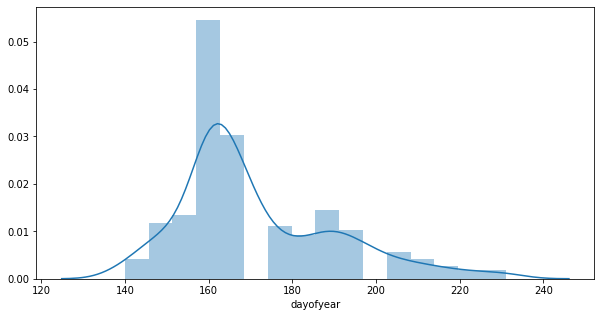

In [113]:
# Regression analysis:
# Average max canopy date is just before day 160 (155-160) it looks like.
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(final['dayofyear'])
plt.show()

In [114]:
# Get variables of interest
y = pd.DataFrame(final, columns= ['dayofyear'])
y = y['dayofyear']

In [115]:
# How can I add categorical data to this model?
X = pd.DataFrame(final, columns = ['actual_max_canopy', 'irrigation_mm', 'actual_precip_mm',
                                         'betweenrowft', 'slope', 'aspect'])

X = pd.DataFrame(final, columns = ['actual_max_canopy','tower_id', 'crop', 'metacrop', 'region', 'subregion',
                                         'irrigation_mm', 'actual_precip_mm',
                                         'betweenrowft', 'slope', 'aspect'])

# Get dummy variables for categorical data:
X2 = pd.get_dummies(X, columns= ['crop', 'metacrop', 'region', 'subregion'])

In [116]:
# Perform regression, get r square
regressor = LinearRegression()  
regressor.fit(X2, y)

r_sq = regressor.score(X2, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.24603196000344388


In [117]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

136.62043508177157
[ 7.36783416e+00  1.75744641e-03  1.46109317e-01 -6.98557955e+00
  1.10363029e+00 -1.97473384e-01  4.57490261e-03  4.28074458e+00
 -9.04621715e+00  4.76547257e+00 -9.04621715e+00  9.04621715e+00
 -6.38528482e-01 -4.18182559e-01 -4.12331486e-01  1.46904253e+00
  2.02384914e+01  1.85839211e+01 -2.42953690e+00 -8.07527959e-01
 -1.41013839e+01 -1.84844644e+00  3.84123684e+00 -5.64302875e+00
  3.31748897e+00 -7.28734459e-02  2.55256480e+00 -1.60591122e+01
 -1.78835896e+01  8.29459060e+00  2.01720542e+00]


In [118]:
# Predict
y_pred = regressor.predict(X2)

In [119]:
# View Coefficients
coeff_df = pd.DataFrame(regressor.coef_, X2.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
actual_max_canopy,7.367834
tower_id,0.001757
irrigation_mm,0.146109
actual_precip_mm,-6.985580
betweenrowft,1.103630
slope,-0.197473
aspect,0.004575
crop_grape,4.280745
crop_pistachio,-9.046217
crop_table_grape,4.765473


In [120]:
df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,189,187.556707
1,168,161.998244
2,189,184.330936
3,189,190.747808
4,161,163.648593
5,154,180.726253
6,210,188.477901
7,189,176.952765
8,154,152.667666
9,168,175.886156


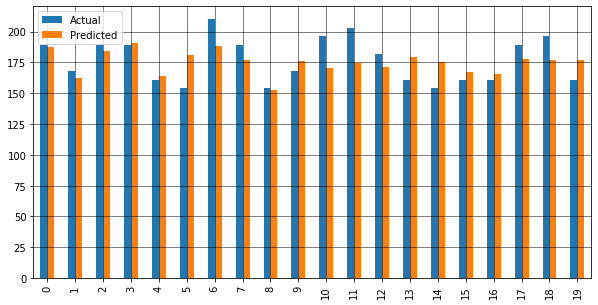

In [121]:
# Plot actual vs predicted values on subset of data
# Can modify df1 size to view more towers
df1 = df.head(20)
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [122]:
# Print out model metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 12.535737820820618
Mean Squared Error: 269.1132291454739
Root Mean Squared Error: 16.40467095511135


# Perform ARIMA 

In [123]:
# get region in weekly data set.
# groupby week using median, get into dataframe, and then pass this to arima
# can do a predictive model for region

# merge
test = pd.merge(towers_clean, towerweekly_clean, on = 'tower_id', how = 'inner')
test2 = test.groupby(by = 'date').median()

# subset
NC = test[test.region == 'NCoast']
CC = test[test.region == 'CCoast']
SV = test[test.region == 'SacValley']
SD = test[test.region == 'SanDiego']
SJV = test[test.region == 'SJV']
Imp = test[test.region == 'Imperial']

# test3 = test.groupby(by = ['date', 'region']).median()
# test4 = test.groupby(['date','region'])[["pri", "tower_id"]].median()
# test_NC = NC.groupby(['date']).median()

In [124]:
# Numbers represents row number
NC2 = NC.groupby(by = ['date']).median() # 33
CC2 = CC.groupby(by = ['date']).median() # 33
SV2 = SV.groupby(by = ['date']).median() # 33
SD2 = SD.groupby(by = ['date']).median() # 33
SJV2 = SJV.groupby(by = ['date']).median() # 33
Imp2 = Imp.groupby(by = ['date']).median() # 9

In [125]:
# Change based on region of interest
# Going to run this on the North Coast region
timeseries2 = NC2['pri']
timeseries2

date
2019-01-07    0.878940
2019-01-14    0.958160
2019-01-21    0.827406
2019-01-28    0.955379
2019-02-04    0.988531
2019-02-11    1.129389
2019-02-18    0.953460
2019-02-25    0.987132
2019-03-04    1.112260
2019-03-11    1.020771
2019-03-18    1.092619
2019-03-25    1.170997
2019-04-01    1.245426
2019-04-08    1.087972
2019-04-15    0.973057
2019-04-22    0.753715
2019-04-29    0.691101
2019-05-06    0.700534
2019-05-13    0.695757
2019-05-20    0.711719
2019-05-27    0.776284
2019-06-03    0.761463
2019-06-10    0.806295
2019-06-17    0.732716
2019-06-24    0.693061
2019-07-01    0.668659
2019-07-08    0.677996
2019-07-15    0.680577
2019-07-22    0.677255
2019-07-29    0.673854
2019-08-05    0.664155
2019-08-12    0.662552
2019-08-19    0.657647
Name: pri, dtype: float64

In [126]:
# Interested in forecasting pri feature.

# Is data stationary?
# Perform Dickey-Fulle test
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(timeseries2.dropna())[1])

p-value: 0.7635851588942527


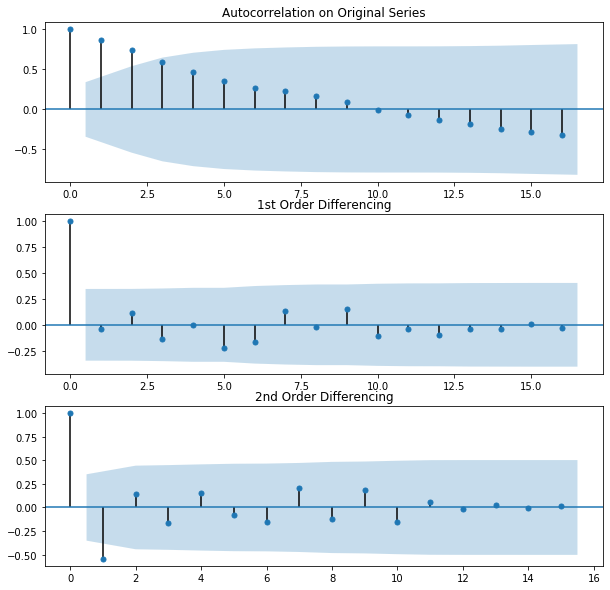

In [127]:
# Find out the order of differencing, or d = ?:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries2, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries2.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries2.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

# d = 1 

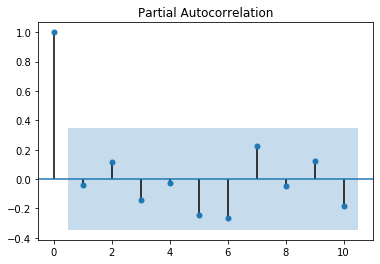

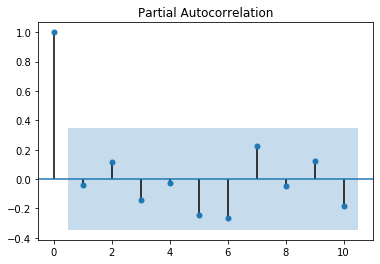

In [128]:
# Determine p term, or number of lags / order of autoregressive terms.
plot_pacf(timeseries2.diff().dropna(), lags=10)
# p = 1

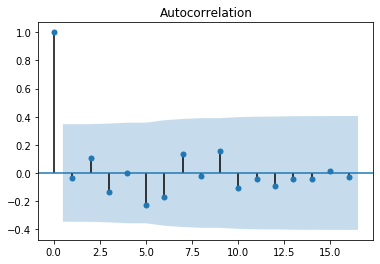

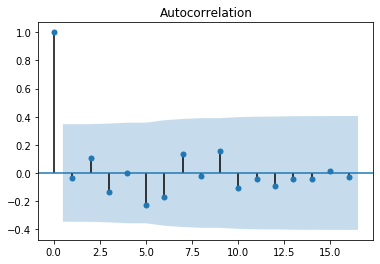

In [129]:
# Determine q, or the number of lagged forecast errors / order of moving average terms. 
plot_acf(timeseries2.diff().dropna())
# q = 1

/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.pri   No. Observations:                   32
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  33.585
Method:                       css-mle   S.D. of innovations              0.085
Date:                Tue, 10 Mar 2020   AIC                            -57.170
Time:                        16:48:01   BIC                            -49.841
Sample:                    01-14-2019   HQIC                           -54.741
                         - 08-19-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0074      0.016     -0.460      0.645      -0.039       0.024
ar.L1.D.pri    -0.5516      0.439     -1.257      0.209      -1.412       0.308
ar.L2.D.pri     0.1348      0.190      0.710    

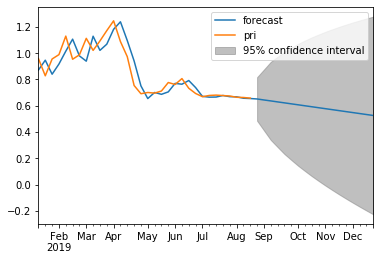

In [130]:
# Run the model 
# Use p,d,q terms just determined. Can modify later.
# Tried with a d term of 2 however it did not change the model by much.
model = ARIMA(timeseries2, order=(2, 1, 1))
results = model.fit()
results.plot_predict(1, 50)
# results.summary()
model_fit = model.fit(disp=0)
print(model_fit.summary())

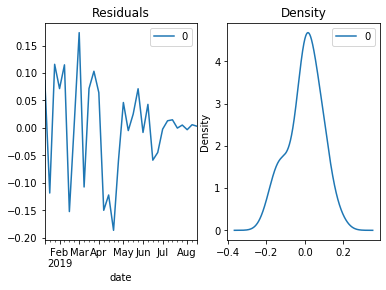

In [131]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

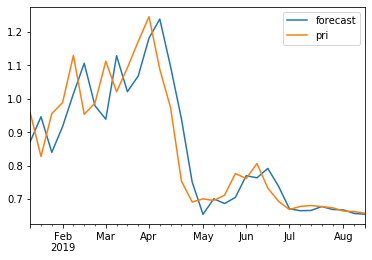

In [132]:
# Actual vs Fitted
# dynamic = false the in-sample lagged values are used for prediction. That is, the model gets trained up 
# until the previous value to make the next prediction. This can make the fitted forecast and actuals 
# look artificially good.
model_fit.plot_predict(dynamic=False)
plt.show()

In [133]:
# Out of time cross validation
# Create Training and Test
train = timeseries2[:20]
test = timeseries2[20:]

/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


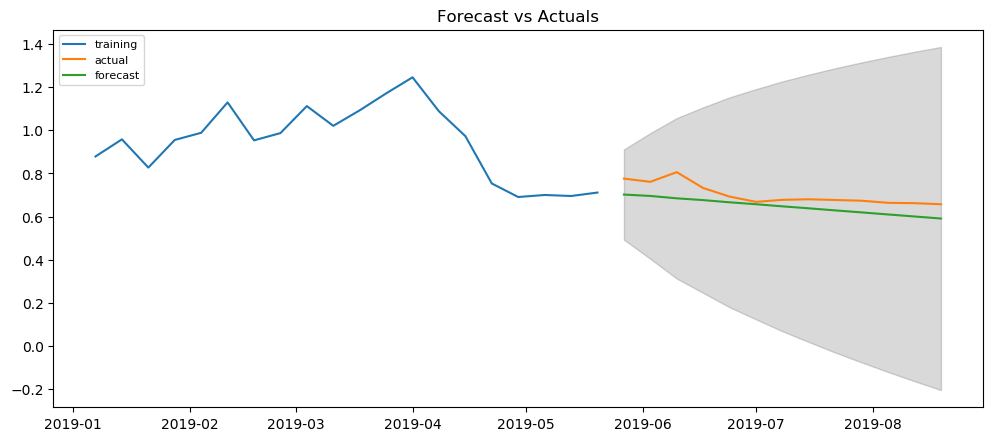

In [134]:
# Build Model
# Adjust p, d, q terms
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(13, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [135]:
# Accuracy metrics
def forecast_accuracy(forecast, actual, fft=False):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.07652918328506754,
 'me': -0.05462440345400139,
 'mae': 0.05462440345400139,
 'mpe': -0.07652918328506754,
 'rmse': 0.06038561159702167,
 'acf1': 0.4354275141955608,
 'corr': 0.8486139177285066,
 'minmax': 0.07652918328506764}

In [136]:
# Auto ARIMA

def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

In [87]:
automodel = arimamodel(timeseries2)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=-52.039, BIC=-46.303, Time=0.138 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=-37.005, BIC=-34.137, Time=0.007 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=-46.679, BIC=-42.378, Time=0.036 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=-54.034, BIC=-49.732, Time=0.055 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=-38.990, BIC=-37.556, Time=0.028 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=-50.551, BIC=-43.381, Time=0.119 seconds
Near non-invertible roots for order (2, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-50.421, BIC=-43.251, Time=0.290 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-52.032, BIC=-46.296, Time=0.112 seconds
Near non-invertible roots for order (0, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (2, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=-45.626, BIC=-39.890, Time=0.053 seconds
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=-48.792, BIC=-40.188, Time=0.162 seconds
Total fit time: 1.013 seconds


/Users/ajeustis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


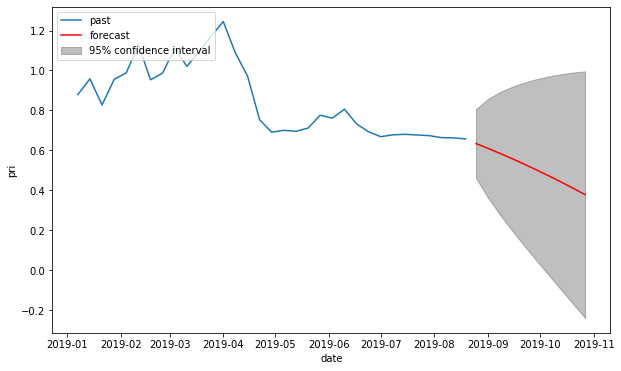

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  30.017
Date:                Tue, 10 Mar 2020   AIC                            -54.034
Time:                        16:49:16   BIC                            -49.732
Sample:                             0   HQIC                           -52.632
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.004     -0.225      0.822      -0.010       0.008
ma.L1         -0.9962      4.378     -0.228      0.820      -9.576       7.584
sigma2         0.0076      0.033      0.231      0.817      -0.057       0.072
===================================================================================
Ljung-Box (Q):                        8.31   Jarque-Bera (JB):                 4.84
Prob(Q):                              1.00   Prob(JB):                         0.09
Heteroskedasticity (H):               0.06   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
# Plot with forecasting
plotarima(10, timeseries2, automodel)
automodel.summary()